# 📌 Entrenamiento de modelos

El objetivo de este notebook es **entrenar modelos para los 6 datasets obtenidos previamente**, ubicados en `datasets/datasets 1-6`.  
Cada dataset varía en la definición de **ventana** y **periodo preictal**, con el fin de evaluar si estos parámetros influyen en la precisión del modelo entrenado.  

### Definición de los datasets

| Dataset | Inicio periodo preictal          | Fin del periodo preictal             | Duración ventana | Solapamiento |
|---------|----------------------------------|--------------------------------------|------------------|--------------|
| 1       | 15 minutos antes de la crisis    | Inicio de la crisis                   | 180 latidos      | 60 latidos   |
| 2       | 15 minutos antes de la crisis    | Inicio de la crisis                   | 120 latidos      | 60 latidos   |
| 3       | 15 minutos antes de la crisis    | Inicio de la crisis                   | 240 latidos      | 60 latidos   |
| 4       | 15 minutos antes de la crisis    | Inicio de la crisis                   | 180 latidos      | 40 latidos   |
| 5       | 15 minutos antes de la crisis    | Inicio de la crisis                   | 180 latidos      | 80 latidos   |
| 6       | 15 minutos antes de la crisis    | 10 minutos luego del fin de la crisis | 180 latidos      | 60 latidos   |


In [1]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import tkinter as tk
from tkinter import filedialog
import openpyxl
import imblearn

📊 Distribución de clases:
clasificacion
no_preictal    3527
preictal        445
Name: count, dtype: int64

📊 Porcentajes de clases:
clasificacion
no_preictal    88.8
preictal       11.2
Name: proportion, dtype: float64


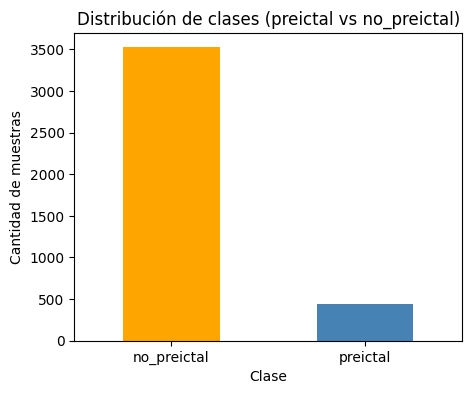

In [6]:
import matplotlib.pyplot as plt

# Conteo de clases
conteo_clases = y.value_counts()
print("📊 Distribución de clases:")
print(conteo_clases)

# Porcentajes
porcentaje_clases = y.value_counts(normalize=True) * 100
print("\n📊 Porcentajes de clases:")
print(porcentaje_clases.round(2))

# Visualización
plt.figure(figsize=(5,4))
conteo_clases.plot(kind="bar", color=["orange","steelblue"])
plt.title("Distribución de clases (preictal vs no_preictal)")
plt.xlabel("Clase")
plt.ylabel("Cantidad de muestras")
plt.xticks(rotation=0)
plt.show()


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# ==============================
# 1) Train/Test split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==============================
# 2) Definir modelo base
# ==============================
rf = RandomForestClassifier(random_state=42, class_weight=None)

# ==============================
# 3) Undersampling
# ==============================
undersample = RandomUnderSampler(random_state=42)
pipe_under = Pipeline(steps=[('undersample', undersample),
                             ('model', rf)])

pipe_under.fit(X_train, y_train)
y_pred_under = pipe_under.predict(X_test)

print("=== 📉 Random Forest con Undersampling ===")
print(confusion_matrix(y_test, y_pred_under))
print(classification_report(y_test, y_pred_under))

# ==============================
# 4) SMOTE Oversampling
# ==============================
smote = SMOTE(random_state=42, k_neighbors=3)
pipe_smote = Pipeline(steps=[('smote', smote),
                             ('model', rf)])

pipe_smote.fit(X_train, y_train)
y_pred_smote = pipe_smote.predict(X_test)

print("\n=== 📈 Random Forest con SMOTE Oversampling ===")
print(confusion_matrix(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))


=== 📉 Random Forest con Undersampling ===
[[511 195]
 [ 39  50]]
              precision    recall  f1-score   support

 no_preictal       0.93      0.72      0.81       706
    preictal       0.20      0.56      0.30        89

    accuracy                           0.71       795
   macro avg       0.57      0.64      0.56       795
weighted avg       0.85      0.71      0.76       795


=== 📈 Random Forest con SMOTE Oversampling ===
[[617  89]
 [ 62  27]]
              precision    recall  f1-score   support

 no_preictal       0.91      0.87      0.89       706
    preictal       0.23      0.30      0.26        89

    accuracy                           0.81       795
   macro avg       0.57      0.59      0.58       795
weighted avg       0.83      0.81      0.82       795



In [9]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# =========================
# Configuración
# =========================
carpeta = r"D:\Epilepsy-Prediction-from-Heartbeat-Signals\datasets\datasets 1-6"
rutas = [os.path.join(carpeta, f"dataset{i}.xlsx") for i in range(1, 7)]

caracteristicas = ['nni_diff_mean', 'CSI', 'hr_std', 'HF_power', 'SampEn', 'pnn50']
columna_etiquetas = "clasificacion"

# =========================
# Funciones auxiliares
# =========================
def compaginar_un_dataset(ruta_excel, caracteristicas, columna_etiquetas, engine="openpyxl"):
    """ Lee todas las hojas de un dataset y devuelve un DataFrame compaginado """
    xls = pd.ExcelFile(ruta_excel, engine=engine)
    df_list = []

    for hoja in xls.sheet_names:
        df_hoja = pd.read_excel(xls, sheet_name=hoja, engine=engine)

        # Filtrar columnas fantasma y asegurar que estén las requeridas
        df_hoja = df_hoja.loc[:, ~df_hoja.columns.astype(str).str.startswith("Unnamed")]
        requeridas = set(caracteristicas + [columna_etiquetas])
        if not requeridas.issubset(df_hoja.columns):
            continue

        df_hoja["__hoja"] = hoja
        df_list.append(df_hoja)

    if not df_list:
        return None

    df = pd.concat(df_list, ignore_index=True)
    return df.loc[:, caracteristicas + [columna_etiquetas, "__hoja"]]

def entrenar_y_reportar(df, caracteristicas, columna_etiquetas, random_state=42):
    """ Entrena dos modelos: Undersampling+RF y SMOTE+RF, y reporta métricas """
    X = df[caracteristicas]
    y = df[columna_etiquetas].astype(str)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    rf = RandomForestClassifier(random_state=random_state)

    # --- Undersampling ---
    pipe_under = Pipeline([("under", RandomUnderSampler(random_state=random_state)),
                           ("rf", rf)])
    pipe_under.fit(X_train, y_train)
    y_pred_u = pipe_under.predict(X_test)

    print("\n=== 📉 Undersampling + RandomForest ===")
    print(confusion_matrix(y_test, y_pred_u))
    print(classification_report(y_test, y_pred_u, digits=3))

    # --- SMOTE ---
    pipe_smote = Pipeline([("smote", SMOTE(random_state=random_state, k_neighbors=3)),
                           ("rf", rf)])
    pipe_smote.fit(X_train, y_train)
    y_pred_s = pipe_smote.predict(X_test)

    print("\n=== 📈 SMOTE + RandomForest ===")
    print(confusion_matrix(y_test, y_pred_s))
    print(classification_report(y_test, y_pred_s, digits=3))

# =========================
# Loop: entrenar modelo por dataset
# =========================
for ruta in rutas:
    nombre = os.path.basename(ruta)
    print(f"\n\n==================== {nombre} ====================")
    df = compaginar_un_dataset(ruta, caracteristicas, columna_etiquetas)

    if df is None or df.empty:
        print("🚫 No se encontraron hojas válidas (faltan columnas).")
        continue

    print(f"✅ Dataset '{nombre}' con {len(df)} filas, {df['__hoja'].nunique()} hojas compaginadas.")
    print("Distribución de clases:", df[columna_etiquetas].value_counts().to_dict())

    entrenar_y_reportar(df, caracteristicas, columna_etiquetas)




==================== dataset1.xlsx ====================
✅ Dataset 'dataset1.xlsx' con 4041 filas, 39 hojas compaginadas.
Distribución de clases: {'no_preictal': 3596, 'preictal': 445}

=== 📉 Undersampling + RandomForest ===
[[481 239]
 [ 40  49]]
              precision    recall  f1-score   support

 no_preictal      0.923     0.668     0.775       720
    preictal      0.170     0.551     0.260        89

    accuracy                          0.655       809
   macro avg      0.547     0.609     0.518       809
weighted avg      0.840     0.655     0.718       809


=== 📈 SMOTE + RandomForest ===
[[640  80]
 [ 62  27]]
              precision    recall  f1-score   support

 no_preictal      0.912     0.889     0.900       720
    preictal      0.252     0.303     0.276        89

    accuracy                          0.824       809
   macro avg      0.582     0.596     0.588       809
weighted avg      0.839     0.824     0.831       809



==================== dataset2.xlsx =====